# Distributed training of ATLAS RPV CNN Classifier

In this notebook, we extend the Train_rpv example to train distributed across nodes
using ipyparallel and Horovod.

* TODO: improve documentation.

In [18]:
# System imports
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

# External imports
import ipyparallel as ipp

import matplotlib.pyplot as plt
%matplotlib notebook

## Connect to ipyparallel cluster

In [2]:
# Use default profile for now
c = ipp.Client()
print('Worker IDs:', c.ids)

Worker IDs: [0, 1, 2, 3]


## Setup the workers

In [3]:
%%px

from __future__ import print_function
from __future__ import division

import os
import socket

import keras
import horovod.keras as hvd

from rpv import load_file, build_model, train_model

[stderr:0] 
/usr/common/software/tensorflow/intel-tensorflow/1.8.0-py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
[stderr:1] 
/usr/common/software/tensorflow/intel-tensorflow/1.8.0-py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
[stderr:2] 
/usr/common/software/tensorflow/intel-tensorflow/1.8.0-py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is d

In [4]:
%%px

# Initialize horovod
hvd.init()
print('MPI rank %i, local rank %i, host %s' %
      (hvd.rank(), hvd.local_rank(), socket.gethostname()))

[stdout:0] MPI rank 3, local rank 0, host nid00039
[stdout:1] MPI rank 2, local rank 0, host nid00038
[stdout:2] MPI rank 0, local rank 0, host nid00036
[stdout:3] MPI rank 1, local rank 0, host nid00037


## Load the data

In [5]:
%%px

# Data config
n_train = 32000 #412416
n_valid = 16000 #137471
n_test = 16000 #137471
input_dir = '/global/cscratch1/sd/sfarrell/atlas-rpv-images'

# Load the data files
train_file = os.path.join(input_dir, 'train.h5')
valid_file = os.path.join(input_dir, 'val.h5')
test_file = os.path.join(input_dir, 'test.h5')
train_input, train_labels, train_weights = load_file(train_file, n_train)
valid_input, valid_labels, valid_weights = load_file(valid_file, n_valid)
test_input, test_labels, test_weights = load_file(test_file, n_test)
print('train shape:', train_input.shape)
print('valid shape:', valid_input.shape)
print('test shape: ', test_input.shape)

[stdout:0] 
train shape: (32000, 64, 64, 1)
valid shape: (16000, 64, 64, 1)
test shape:  (16000, 64, 64, 1)
[stdout:1] 
train shape: (32000, 64, 64, 1)
valid shape: (16000, 64, 64, 1)
test shape:  (16000, 64, 64, 1)
[stdout:2] 
train shape: (32000, 64, 64, 1)
valid shape: (16000, 64, 64, 1)
test shape:  (16000, 64, 64, 1)
[stdout:3] 
train shape: (32000, 64, 64, 1)
valid shape: (16000, 64, 64, 1)
test shape:  (16000, 64, 64, 1)


## Build and train the model

In [6]:
%%px

# Model config
h1, h2, h3, h4, h5 = 64, 128, 256, 256, 512
optimizer = keras.optimizers.Adam
lr = 0.001 * hvd.size()

# Training config
batch_size = 128
n_epochs = 8
use_weights = False

# Build the model
model = build_model(train_input.shape[1:],
                    h1=h1, h2=h2, h3=h3, h4=h4, h5=h5,
                    optimizer=optimizer, lr=lr)
if hvd.rank() == 0:
    model.summary()

[stdout:2] 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               33554944 

In [7]:
%%px

# Train the model
history = train_model(model, train_input=train_input, train_labels=train_labels,
                      valid_input=valid_input, valid_labels=valid_labels,
                      batch_size=batch_size, n_epochs=n_epochs)

[stdout:0] 
Train on 32000 samples, validate on 16000 samples
Epoch 1/8
 - 212s - loss: 0.3071 - acc: 0.8830 - val_loss: 0.2334 - val_acc: 0.9059
Epoch 2/8
 - 208s - loss: 0.2103 - acc: 0.9161 - val_loss: 0.2585 - val_acc: 0.9009
Epoch 3/8
 - 209s - loss: 0.1908 - acc: 0.9323 - val_loss: 0.2637 - val_acc: 0.8989
Epoch 4/8
 - 212s - loss: 0.0962 - acc: 0.9677 - val_loss: 0.3265 - val_acc: 0.9148
Epoch 5/8
 - 211s - loss: 0.0095 - acc: 0.9976 - val_loss: 0.4358 - val_acc: 0.9300
Epoch 6/8
 - 211s - loss: 7.3134e-04 - acc: 0.9999 - val_loss: 0.4400 - val_acc: 0.9348
Epoch 7/8
 - 209s - loss: 1.7374e-05 - acc: 1.0000 - val_loss: 0.4596 - val_acc: 0.9353
Epoch 8/8
 - 207s - loss: 7.6616e-06 - acc: 1.0000 - val_loss: 0.4724 - val_acc: 0.9347
[stdout:1] 
Train on 32000 samples, validate on 16000 samples
Epoch 1/8
 - 216s - loss: 0.3084 - acc: 0.8822 - val_loss: 0.2334 - val_acc: 0.9059
Epoch 2/8
 - 212s - loss: 0.2115 - acc: 0.9152 - val_loss: 0.2585 - val_acc: 0.9009
Epoch 3/8
 - 213s - loss

In [8]:
# Can I get worker-local variables out?
epochs = c[0].get('history.epoch')
histories = c[:].get('history.history')

<IPython.core.display.Javascript object>


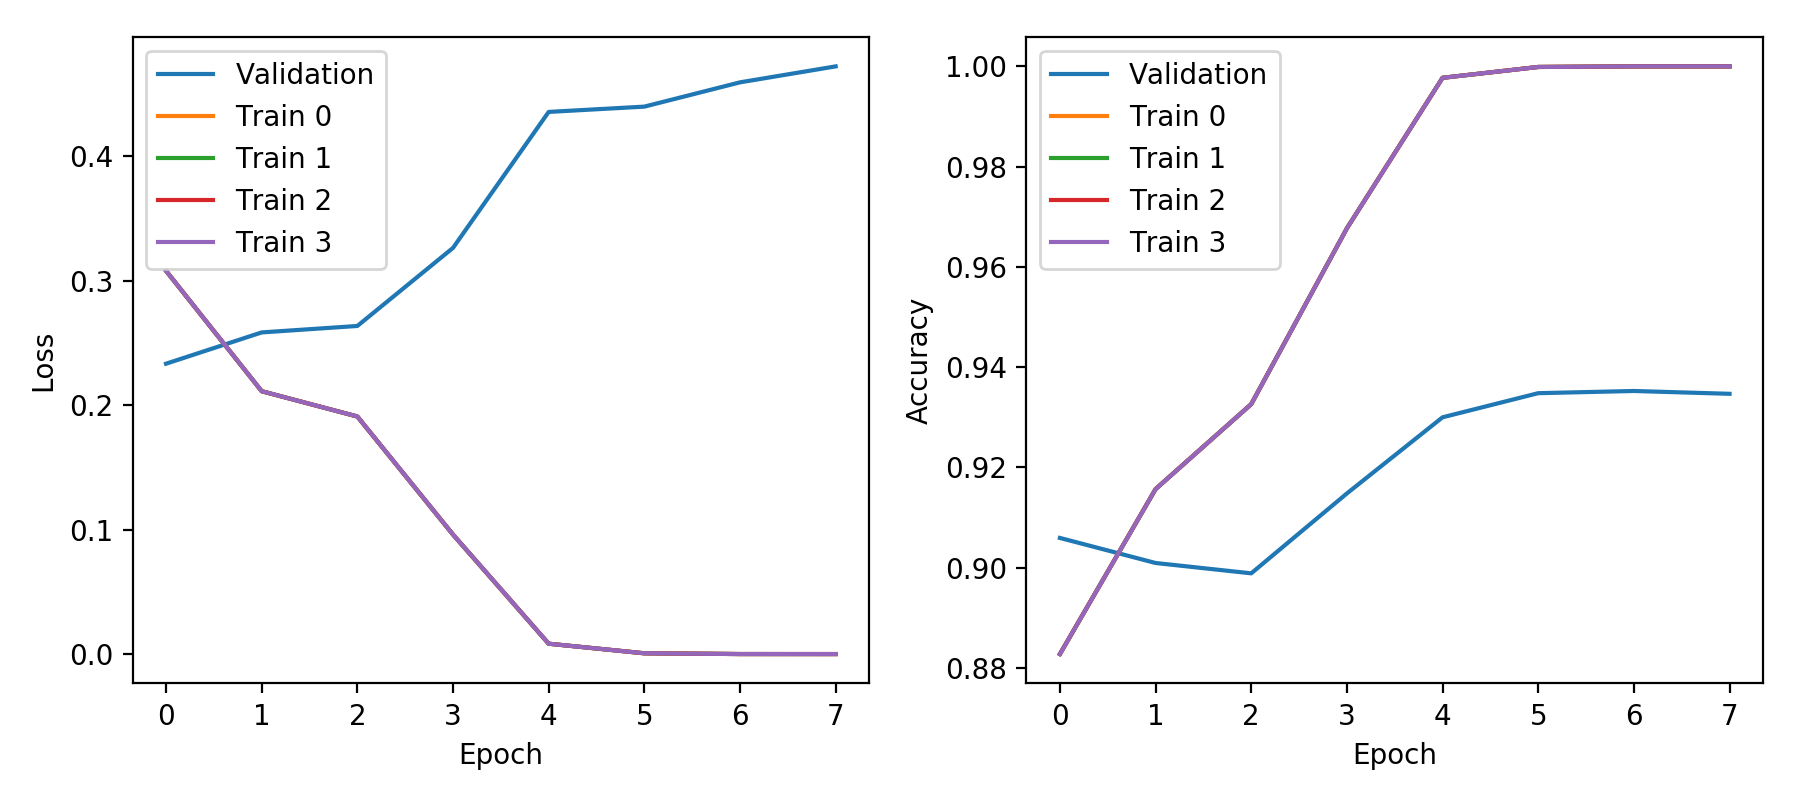

In [19]:
plt.figure(figsize=(9,4))

# Plot the loss
plt.subplot(121)
plt.plot(epochs, histories[0]['val_loss'], label='Validation')
for i, h in enumerate(histories):
    plt.plot(epochs, h['loss'], label='Train %i' % i)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

# Plot the accuracy
plt.subplot(122)
plt.plot(epochs, histories[0]['val_acc'], label='Validation')
for i, h in enumerate(histories):
    plt.plot(epochs, h['acc'], label='Train %i' % i)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()

## Evaluate on the test set

In [10]:
from sklearn import metrics

def summarize_metrics(labels, outputs, threshold=0.5, weights=None):
    preds = outputs > threshold
    #print('Metrics summaries with threshold of %.3f' % threshold)
    print('Accuracy:   %.4f' % metrics.accuracy_score(labels, preds, sample_weight=weights))
    print('Purity:     %.4f' % metrics.precision_score(labels, preds, sample_weight=weights))
    print('Efficiency: %.4f' % metrics.recall_score(labels, preds, sample_weight=weights))

def draw_roc(labels, outputs, weights=None, ax=None):
    fpr, tpr, _ = metrics.roc_curve(labels, outputs, sample_weight=weights)
    auc = metrics.roc_auc_score(labels, outputs, sample_weight=weights)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='CNN, AUC=%.3f' % auc)
    ax.plot([0, 1], [0, 1], '--', label='Random')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc=0)

In [13]:
%%px

test_output = model.predict(test_input)
test_output = test_output.squeeze(-1)
score = model.evaluate(test_input, test_labels, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

[stdout:0] 
Test loss: 0.4729059347630805
Test accuracy: 0.934
[stdout:1] 
Test loss: 0.4729059347630805
Test accuracy: 0.934
[stdout:2] 
Test loss: 0.4729059347630805
Test accuracy: 0.934
[stdout:3] 
Test loss: 0.4729059347630805
Test accuracy: 0.934


In [14]:
test_output = c[0].get('test_output')
test_labels = c[0].get('test_labels')
test_weights = c[0].get('test_weights')

In [15]:
# Unweighted results
print('Unweighted metrics')
summarize_metrics(test_labels, test_output)
print()

# Weighted results
print('Weighted metrics')
summarize_metrics(test_labels, test_output, weights=test_weights)

Unweighted metrics
Accuracy:   0.9340
Purity:     0.8957
Efficiency: 0.9586

Weighted metrics
Accuracy:   0.5051
Purity:     0.0001
Efficiency: 0.9586


<IPython.core.display.Javascript object>


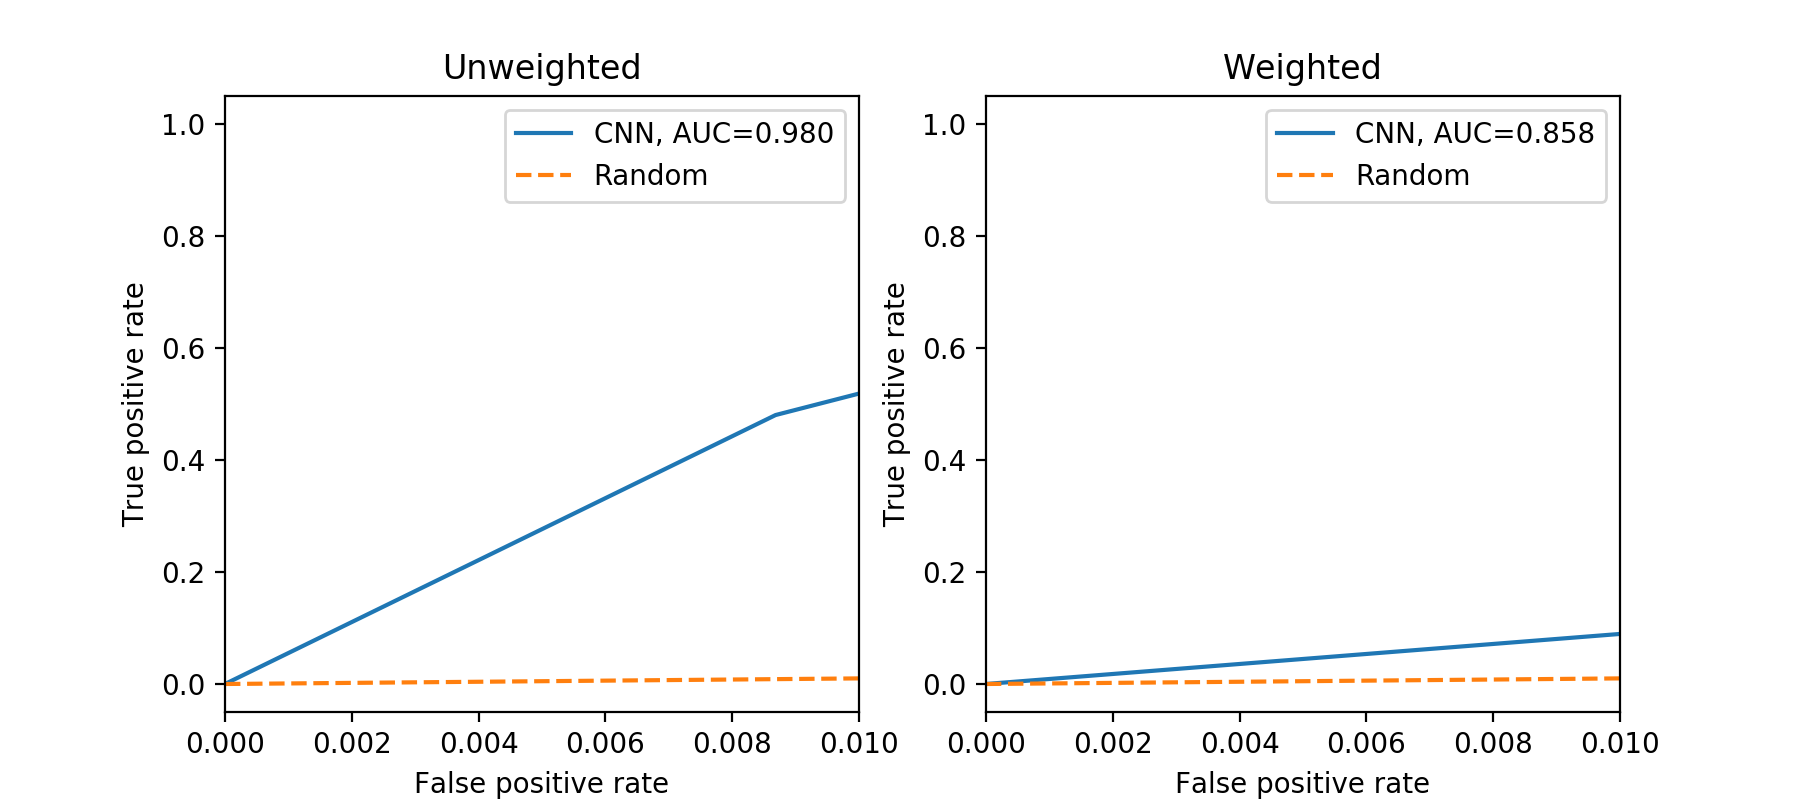

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
draw_roc(test_labels, test_output, ax=axs[0])
draw_roc(test_labels, test_output, ax=axs[1], weights=test_weights)
axs[0].set_xlim([0, 0.01])
axs[0].set_title('Unweighted')
axs[1].set_xlim([0, 0.01])
axs[1].set_title('Weighted');

<IPython.core.display.Javascript object>


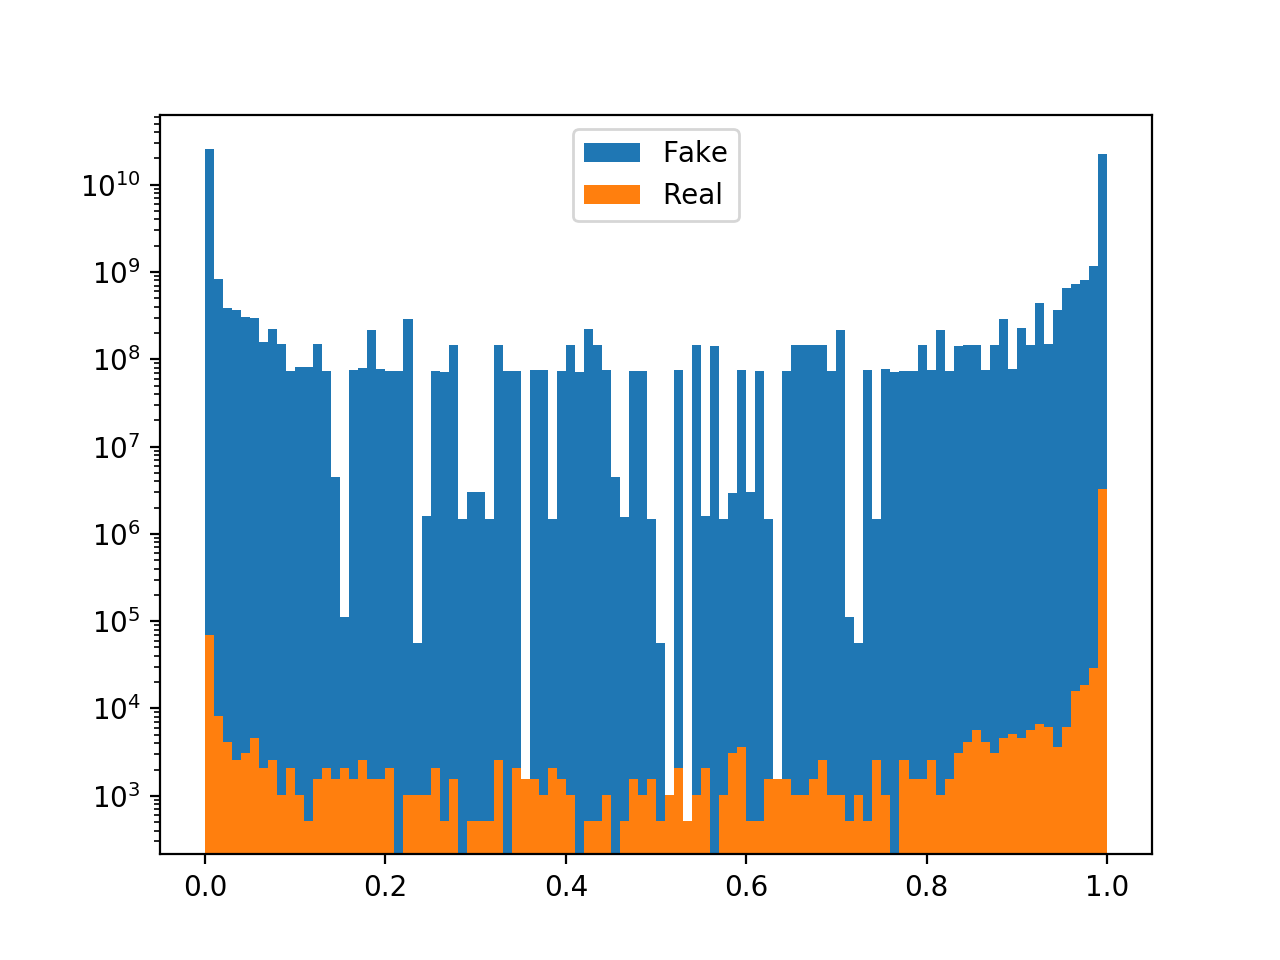

In [21]:
# Visualize the model output
plt.figure()

# Select real/fake sample model outputs
real_idx = test_labels > 0.5
fake_idx = (real_idx == False)

binning=dict(bins=100, range=(0, 1), log=True)
plt.hist(test_output[fake_idx], weights=test_weights[fake_idx], label='Fake', **binning)
plt.hist(test_output[real_idx], weights=test_weights[real_idx], label='Real', **binning)
plt.legend(loc=0);